In [1]:
import os, re, glob, json
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']=''

import numpy as np
import pandas as pd

from PIL import Image
from collections import Counter
from sklearn.model_selection import train_test_split
from ohia.generators import PlantNetGenerator
from ohia.encoders import FastLabelEncoder
from ohia.utils import crop_square
from train import get_model, get_model_path

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from jupyterthemes import jtplot 
jtplot.reset()

Using TensorFlow backend.


#### Preliminaries

In [2]:
# get list of images and labels
FILE_PATH = '/home/matt/repos/ohia.ai/data'
file_list = glob.glob(f'{FILE_PATH}/preprocessed_images/scraped_filtered/**/*.jpg', recursive=True)
label_list = [re.split('/', f)[-2] for f in file_list]

# encode label names with ids
fle = FastLabelEncoder()
label_ids = fle.fit_transform(label_list)

# id to label lookup
id2label = {int(fle.transform([label])):label for label in np.unique(label_list)}
label2id = {id2label[i]:i for i in np.unique(label_ids)}

# split data
train_files, valid_files, train_ids, valid_ids \
    = train_test_split(file_list, label_ids, test_size=0.1, random_state=1)

# create generators
n_classes = len(np.unique(label_list))
valid_generator = PlantNetGenerator(
    valid_files, valid_ids, n_classes,
    batch_size=32,
    augment=False,
    shuffle=False
)

# load model
model = get_model('mobilenetv1', n_classes, training_type=0)
model_path = get_model_path('mobilenetv1', 0, 1, 32, False)
best_weights = glob.glob(f'{model_path}/**.h5')
best_weights = np.sort(best_weights)[-1]
model.load_weights(best_weights)

#### Top 1, Top 3, Top 5 Accuracy

In [3]:
# get sorted predictions
valid_preds = model.predict_generator(valid_generator)
pred_ids_sort = np.argsort(valid_preds, axis=1)

In [4]:
# get accuracy matrix
n_preds = len(valid_preds)
accuracy_matrix = pred_ids_sort == np.expand_dims(valid_ids[:n_preds], -1)

In [5]:
# get aggregate accuracies
top_1 = accuracy_matrix[:,-1:].sum(axis=1)>0
top_3 = accuracy_matrix[:,-3:].sum(axis=1)>0
top_5 = accuracy_matrix[:,-5:].sum(axis=1)>0
print(
    f'top 1:{100*np.mean(top_1): 0.2f}%,   '
    f'top 3:{100*np.mean(top_3): 0.2f}%,   '
    f'top 5:{100*np.mean(top_5): 0.2f}%'
)

top 1: 73.76%,   top 3: 88.74%,   top 5: 92.51%


#### Per Plant Results

In [72]:
# # aggregate accuracies
valid_labels = [id2label[i] for i in valid_ids[:n_preds]]
plant_results = pd.DataFrame({
    "labels": valid_labels,
    "top_1": top_1,
    "top_3": top_3,
    "top_5": top_5
})

plant_results = plant_results.groupby(["labels"])
plant_results = plant_results.agg(['mean'])
plant_results.reset_index(inplace=True)
plant_results.columns = plant_results.columns.droplevel(1)

# add counts
counts = Counter([id2label[i] for i in train_ids])
counts = pd.DataFrame({
   'counts': list(counts.values()),
    'labels': list(counts.keys())
})

plant_results = pd.merge(plant_results, counts, on='labels')
plant_results.to_csv('results/results.csv', index=False)

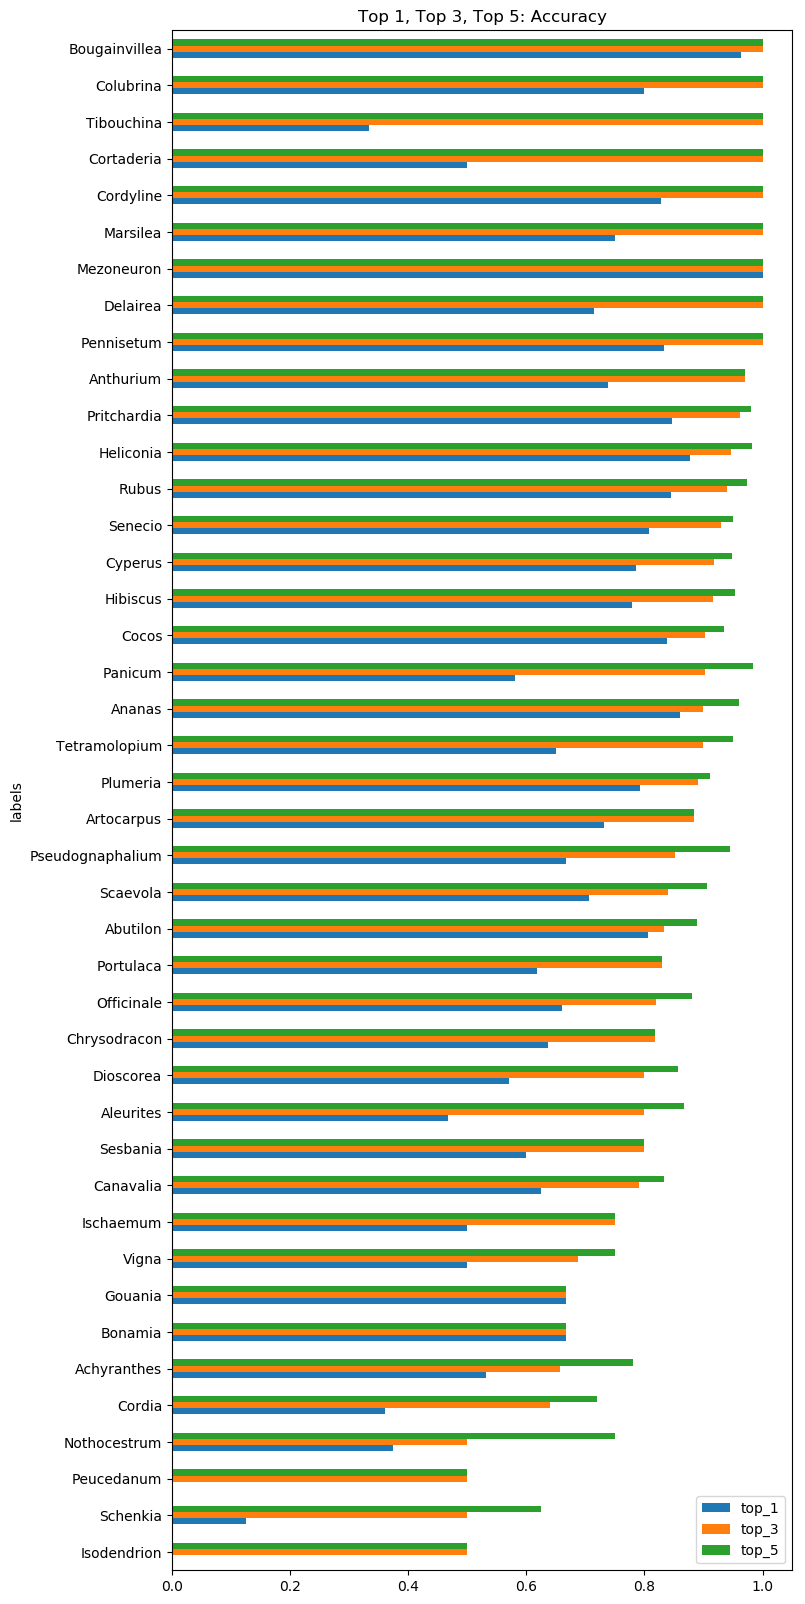

In [7]:
jtplot.reset()
plot_data = plant_results.set_index('labels').drop('counts', 1)
plot_data.sort_values('top_3', inplace=True)
plot_data.plot.barh(
    figsize=(8,20),
    title='Top 1, Top 3, Top 5: Accuracy'
)
plt.show()

#### Accuracy Vs. Training Size

/home/matt/anaconda3/envs/kaggle/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


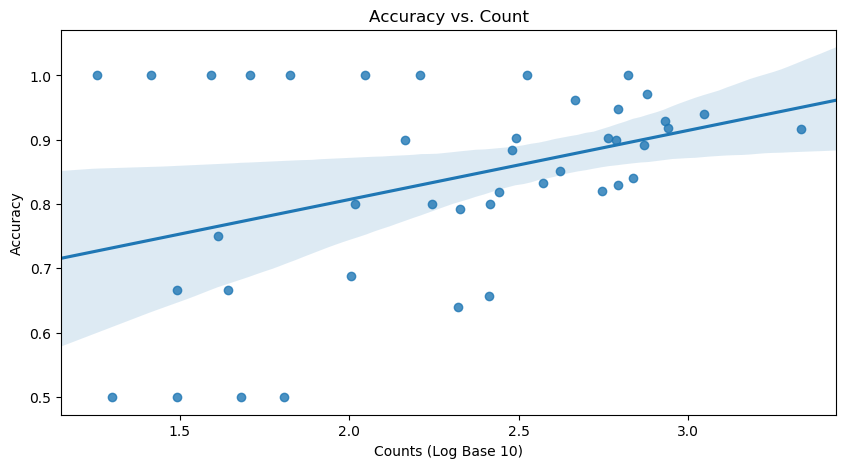

In [8]:
jtplot.reset()
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title('Accuracy vs. Count')
ax.set_xlabel('Counts (Log Base 10)')
ax.set_ylabel('Accuracy')
sns.regplot(
    np.log10(plant_results['counts'].values),
    plant_results['top_3'].values,
    ax=ax
)
plt.show()

#### Typical Images

In [9]:
def get_random_plant_file(plant_name, n_images=1):
    subset_files = [f for f in train_files if plant_name in f]
    return np.random.choice(subset_files, n_images, replace=False)

def file2array(f):
    img = np.array(Image.open(f))/255
    img = crop_square(img)
    return img

In [119]:
def plot_typical_grid(plant_name, save_fig=False):    
    
    plant_files = get_random_plant_file(plant_name, 9)
    
    jtplot.reset()
    fig = plt.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(3, 3)
    gs.update(wspace=0.01, hspace=0.1)
    
    for i in range(9):
        ax = plt.subplot(gs[i])
        ax.imshow(file2array(plant_files[i]))
        ax.set_aspect('equal')
        ax.set_xticklabels([])
        ax.set_yticklabels([])        
        ax.axis('off')
    
    plt.show()
    if save_fig:
        save_name = f'/home/matt/repos/ohia.ai/figures/typical/{plant_name}.png'
        fig.savefig(save_name, bbox_inches='tight')

In [ ]:
# loop through all genera    
for plant in np.unique(label_list):
    plot_typical_grid(plant, True)   
    plt.close()

#### False Positive Images
Images that the neural network thinks is a certain plant but isn't.

In [34]:
def plot_false_positives(plant_name, actual_indexs, actual_probs,
                         predicted_probs, save_fig=False):
    
    jtplot.reset()
    fig = plt.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(2, 2)
    gs.update(wspace=0.01, hspace=0.2)
    
    z = zip(actual_indexs, actual_probs, predicted_probs)
    for i, (ai, ap, pp) in enumerate(z):
        ax = plt.subplot(gs[i])
        ax.imshow(file2array(valid_files[ai]))
        ax.set_aspect('equal')
        ax.set_xticklabels([])
        ax.set_yticklabels([])        
        ax.axis('off')
        ax.set_title(
            f'Actual: {valid_labels[ai]} ({100*ap:0.2f}%)\n'
            f'Predicted: {plant_name} ({100*pp:0.2f}%)'
        )
        
    plt.show()
    if save_fig:
        save_name = f'/home/matt/repos/ohia.ai/figures/false_positives/{plant_name}.png'
        fig.savefig(save_name, bbox_inches='tight')

In [ ]:
for plant_id in np.unique(label_ids):
    plant_probs = valid_preds.copy()
    plant_probs[valid_ids[:n_preds] == plant_id] = 0
    
    actual_indexs = np.argsort(plant_probs[:, plant_id])[::-1][:4]
    actual_probs = plant_probs[actual_indexs, valid_ids[actual_indexs]]
    predicted_probs = plant_probs[actual_indexs, plant_id]
    
    plot_false_positives(
        plant_name=id2label[plant_id],
        actual_indexs=actual_indexs,
        actual_probs=actual_probs,
        predicted_probs=predicted_probs,
        save_fig=True
    )

    plt.close()

#### False Negative Images
Images that the neural network thinks is not a certain plant but actually is.

In [61]:
def plot_false_negatives(plant_name, actual_indexs, actual_probs,
                         predicted_ids, predicted_probs, save_fig=False):
    
    jtplot.reset()
    fig = plt.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(2, 2)
    gs.update(wspace=0.01, hspace=0.2)
    
    z = zip(actual_indexs, actual_probs, predicted_ids, predicted_probs)
    for i, (ai, ap, pi, pp) in enumerate(z):
        ax = plt.subplot(gs[i])
        ax.imshow(file2array(valid_files[ai]))
        ax.set_aspect('equal')
        ax.set_xticklabels([])
        ax.set_yticklabels([])        
        ax.axis('off')
        ax.set_title(
            f'Actual: {plant_name} ({100*ap:0.2f}%)\n'
            f'Predicted: {id2label[pi]} ({100*pp:0.2f}%)'
        )
        
    plt.show()
    if save_fig:
        save_name = f'/home/matt/repos/ohia.ai/figures/false_negatives/{plant_name}.png'
        fig.savefig(save_name, bbox_inches='tight')

In [ ]:
for plant_id in np.unique(label_ids):
    plant_probs = valid_preds.copy()
    plant_probs[valid_ids[:n_preds] != plant_id] = np.nan
    
    actual_indexs = np.argsort(plant_probs[:, plant_id])[:4]
    actual_probs = plant_probs[actual_indexs, valid_ids[actual_indexs]]
    
    plant_probs = valid_preds.copy()
    predicted_ids = plant_probs[actual_indexs].argmax(1)
    predicted_probs = plant_probs[actual_indexs, predicted_ids]    

    
    plot_false_negatives(
        plant_name=id2label[plant_id],
        actual_indexs=actual_indexs,
        actual_probs=actual_probs,
        predicted_ids=predicted_ids,
        predicted_probs=predicted_probs,
        save_fig=True
    )

    plt.close()